# Model selection and prediction

#### Demo, showing data preparation, model tuning and evaluation in scikit-learn

#### Author: Victor Kitov (v.v.kitov@yandex.ru)

In [4]:
%pylab inline
%precision 6
%load_ext line_profiler
%load_ext autoreload
%autoreload 1

Populating the interactive namespace from numpy and matplotlib


In [5]:
import pandas as pd
import sklearn as skl
import sklearn

In [6]:
from common.feature_transformations import get_one_hot_encoding, get_probability_encoding
from common.visualize.method import print_decision_tree
from common.classes.Struct import Struct
from common.functions import all_nums, vec, row
from pdb import set_trace as bp

In [7]:
from common.visualize.method import print_feature_importances, show_feature_importances

In [8]:
pd.options.display.max_colwidth=100
np.set_printoptions(linewidth=140,edgeitems=10)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
rcParams['figure.figsize'] = (8.0, 5.0)

### Learn more

[Short pandas tutorial](http://pandas.pydata.org/pandas-docs/stable/10min.html)

[Full pandas documentation](http://pandas.pydata.org/pandas-docs/stable/index.html)

## Global modelling workflow:

1. load data
1. explore data
1. clean data
    * remove constant features
    * remove features with low variation
    * remove not relevant features
    * remove not relevant objects (that are too old or follow a wrong model)
1. deal with missing values
    * remove?
    * fill with mean/median/mode?
    * predict using other features?  
1. filter outliers 
1. transform features
    * discrete features to one-hot-encoding or probability encoding
    * scaling 
    * non-linear transform (e.g. log)
    * make features as functions of other features
1. for each model class find optimal model parameters on cross-validation
1. compare models (each with its best parameters)
1. select best model and refit it using all available data
1. apply best model to new data

# Feature description

In [9]:
columns = 'A1 A2 A3 A4 A5 A6 A7 A8 A9 A10 A11 A12 A13 A14 y'.split()
Z = pd.read_csv(r'Data/credit_approval.dat', names=columns, skipinitialspace=True, sep=' ')
Z.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,y
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [10]:
unique(Z.y,return_counts=1)

(array([0, 1], dtype=int64), array([383, 307], dtype=int64))

In [11]:
Z.isnull().sum().sum()

0

In [12]:
all_nums(Z)

SUCCESS, all columns have numbers.



## Data preparation

### Dealing with discrete features

In [13]:
F=Struct() # features
F.original = list(Z.columns)
F.original.remove('y')

In [14]:
F.original

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14']

In [15]:
F.continious = 'A2 A3 A7 A10 A13 A14'.split()
F.discrete = 'A1 A4 A5 A6 A8 A9 A11 A12'.split()

In [17]:
F.discrete_one_hot = []
for col in F.discrete:
    print('Making one-hot-encoding of %s'%col)
    feature_one_hot = get_one_hot_encoding(Z[col])
    Z = pd.concat([Z, feature_one_hot],axis=1)
    F.discrete_one_hot += list(feature_one_hot.columns)

Making one-hot-encoding of A1
Making one-hot-encoding of A4
Making one-hot-encoding of A5
Making one-hot-encoding of A6
Making one-hot-encoding of A8
Making one-hot-encoding of A9
Making one-hot-encoding of A11
Making one-hot-encoding of A12


In [22]:
Z[F.continious].head()

,A2,A3,A7,A10,A13,A14
0,22.08,11.46,1.585,0,100,1213
1,22.67,7.00,0.165,0,160,1
2,29.58,1.75,1.250,0,280,1
3,21.67,11.50,0.000,11,0,1
4,20.17,8.17,1.960,14,60,159


In [23]:
F.continious_norm = []
for col in F.continious:
    Z[col+'_norm'] = (Z[col]-mean(Z[col]))/std(Z[col])
    F.continious_norm.append(col+'_norm')
    print('Normalized %s'%col)

Normalized A2
Normalized A3
Normalized A7
Normalized A10
Normalized A13
Normalized A14


In [24]:
F.continious_norm = []
for col in F.continious:
    Z[col+'_norm'] = (Z[col]-mean(Z[col]))/std(Z[col])
    F.continious_norm.append(col+'_norm')
    print('Normalized %s'%col)

Normalized A2
Normalized A3
Normalized A7
Normalized A10
Normalized A13
Normalized A14


In [25]:
F.continious_norm_range = []
for col in F.continious:
    Z[col+'_norm_range'] = (Z[col]-min(Z[col]))/(max(Z[col])-min(Z[col]))
    F.continious_norm.append(col+'_norm')
    print('Range-normalized %s'%col)

Range-normalized A2
Range-normalized A3
Range-normalized A7
Range-normalized A10
Range-normalized A13
Range-normalized A14


## Converting types to more convenient

In [26]:
features = list(Z.columns)
features.remove('y')

Z[features] = Z[features].astype(float32)
Z.y = Z.y.astype(int)  

## Splitting on train/test set

In [ ]:
len(Z)

In [27]:
N=len(Z)
Z.index=arange(N)

inds = arange(N)
np.random.seed(0)
np.random.shuffle(inds)

N1 = int(0.6*N)

train_inds = inds[:N1]
test_inds = inds[N1:]

In [28]:
train_sels = zeros(N,dtype=bool)
test_sels = zeros(N,dtype=bool)

train_sels[train_inds] = True
test_sels[test_inds] = True

In [33]:
X_train = Z.loc[train_inds, F.continious].values
Y_train = Z.loc[train_inds, 'y'].values

X_test = Z.loc[test_inds, F.continious].values
Y_test = Z.loc[test_inds, 'y'].values


## K-nearest neighbour

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
clf = KNeighborsClassifier()

In [34]:
len(X_train)

414

In [35]:
clf.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [36]:
clf.predict(X_test[:10])

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

In [39]:
clf.predict_proba(X_test[:5])

array([[ 0.8,  0.2],
       [ 0.8,  0.2],
       [ 0.6,  0.4],
       [ 0. ,  1. ],
       [ 1. ,  0. ]])

In [38]:
clf.classes_

array([0, 1])

### Specific methods

In [40]:
clf.kneighbors(row(X_train[0]), return_distance=0)

array([[  0, 199, 238, 193, 289]], dtype=int64)

In [ ]:
clf.kneighbors(X_train[:2], return_distance=0)

# Quality evaluation

In [41]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2)

In [42]:
clf.fit(X_train,Y_train)
Y_hat = clf.predict(X_test)
P_hat = clf.predict_proba(X_test)[:,1]

In [43]:
skl.metrics.accuracy_score(Y_test, Y_hat)

0.652174

In [44]:
sklearn.metrics.confusion_matrix(Y_test, Y_hat)
# By definition a confusion matrix C is such that C_{i, j} is equal to the number of observations known to be in group i 
# but predicted to be in group j.

array([[120,  30],
       [ 66,  60]])

#### Log-likelihood score

In [45]:
sum(log(P_hat))

-inf

#### Brier loss

In [ ]:
skl.metrics.brier_score_loss(Y_test, P_hat)

## Optimizing parameters

In [46]:
from common.visualize.method import show_param_dependency

0| 12| 25| 38| 50| 62| 75| 88| 100.0| 
Top accuracy = 0.7126 for n_neighbors=15


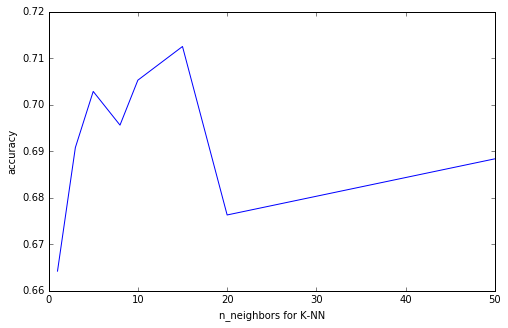

In [47]:
clf = KNeighborsClassifier(n_neighbors=5)
show_param_dependency(clf, X_train, Y_train, param_name='n_neighbors', param_vals=[1,3,5,8,10,15,20,50], x_label='n_neighbors for K-NN')

## Grid search optimization

In [48]:
from sklearn.grid_search import GridSearchCV

In [49]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2)
param_grid = {'n_neighbors':[1,3,5,8,10,15,20,50], 'p':[1,2,4,6]}
clf = GridSearchCV(clf, param_grid, n_jobs=-1, refit=True)

In [50]:
clf.fit(X_train,Y_train)
bbest_score_, clf.best_params_

(0.719807, {'n_neighbors': 8, 'p': 1})

* how adding information about discrete features improve classification?
* is probability encoding or one-hot encoding or both better?
* should we use continious features or normalized continious features?
* which type of normalization is better?
* are there any outliers?
* will our accuracy improve, if we exclude outliers from the training set?
* visualize features
* visualize dependency between output and features
* what ideas of feature transformations can we get from looking at these visualizations?
* can our data be clustered into different groups?
* can cluster information be a useful feature for classification?
* should we reweight observations while training?
* etc.